# Import our in-house package and dependencies
Should install relevant dependencies if there is a conflict

In [1]:
import RoPeR
from RoPeR import bandpass, bgr, energy_eq, gain, prestitch

In [2]:
import os
from tqdm import tqdm
from pds4_tools.reader.core import pds4_read
import numpy as np
import matplotlib.pyplot as plt

# Load the RoPeR data from a folder on our computer which contains the data files

In [110]:
'''
Retrieving files and sorting them
'''
n, m = 0, 10 # 0-109, load all 109 files
data_dir = '/Users/coltenrodriguez/Desktop/Senior_Thesis/RoPeR_LF' # were data

In [111]:
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if '.2CL' in f]
files = sorted(files, key=lambda f: int(f[-10:-6]))[n:m]
length = len(files)

sample_depth = {6000:15000, 4000:10000, 2000:5000, 1000:2500} # number of total pixels in either R/I data: nanoseconds penetration
observable_depth_ns = 1200 # Arbitaraty value

In [112]:
from collections import Counter, defaultdict
'''
Check inhomogenous data (e.g. not all files are LF). also get the effective data legnth (to get ns/px)
'''

effective_data_lens = [info[8] for info in [pds4_read(file, quiet=True)[0].data[0] for file in files]] # Just take the metadata associated with the first trace, as each trace in each file will be the same


if len(set(effective_data_lens)) == 1:
    print(f"Input data is homogenous. Effective data length is {effective_data_lens[0]} bytes. \n {effective_data_lens[0]/8} fpn for real data -- {(effective_data_lens[0]/8)/sample_depth[effective_data_lens[0]/8]} px/ns")
    half_length = int(effective_data_lens[0]/8)
    px_per_ns = half_length/sample_depth[effective_data_lens[0]/8]
else:
    print("Inhomogenous data types. Check that all files are LF or have the same effective data length")

Input data is homogenous. Effective data length is 48000 bytes. 
 6000.0 fpn for real data -- 0.4 px/ns


In [113]:
remove_air = 0

In [114]:
'''
Stitching multiple data files together and gathering some preprocessing data for each file
'''
phase = [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

sample_meta = None
for f, i, j in zip(files, range(0, length), tqdm(range(length-1))): 
    if n<=i<=m:
        fdata = pds4_read(f, quiet=True)[0].data
        if len(set([int.from_bytes(d[6], 'big', signed=False) for d in fdata])) > 1:
            raise Exception("Trigger mode is not homogenously fixed_distance")
        
        sample_meta = fdata[0] # might be useless
        scan2d = np.array([d[9] for d in fdata])
        real_part_scan2d = np.array(scan2d[:, :half_length]).T[remove_air:, :]

        sample_depth_px, real_part_scan2d_depth_adj = prestitch.depth_correction(real_part_scan2d, px_per_ns, observable_depth_ns)
        real_part_scan2d_depth_self_adj = prestitch.remove_self_detection(real_part_scan2d_depth_adj)
        real_part_scan2d_depth_self_phase_adj = prestitch.phase_correction(real_part_scan2d_depth_self_adj, phase[i])
    
        # Assume this is all interpreted
        yaw = np.array([d[23] for d in fdata])
        pos_x = np.array([d[19] for d in fdata])
        pos_y = np.array([d[20] for d in fdata])
        pos_z = np.array([d[21] for d in fdata])
        if i == n:
            raw = real_part_scan2d_depth_adj
            self_detection = real_part_scan2d_depth_self_adj
            phase_offset = real_part_scan2d_depth_self_phase_adj
            yaws = yaw
            poss_x, poss_y, poss_z = pos_x, pos_y, pos_z
            trace_dist_m = np.sum(np.array([int.from_bytes(d[7], 'big', signed=False) for d in fdata])*10e-3)
        else:
            raw = np.concatenate((raw, real_part_scan2d_depth_adj), axis=1)
            self_detection = np.concatenate((self_detection, real_part_scan2d_depth_self_adj), axis=1)
            phase_offset = np.concatenate((phase_offset, real_part_scan2d_depth_self_phase_adj), axis=1)
            yaws = np.concatenate((yaws, yaw))
            poss_x, poss_y, poss_z = np.concatenate((poss_x, pos_x)), np.concatenate((poss_y, pos_y)), np.concatenate((poss_z, pos_z))
            trace_dist_m+=np.sum(np.array([int.from_bytes(d[7], 'big', signed=False) for d in fdata])*10e-3)

100%|███████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  9.00it/s]


In [115]:
trace_dist_m

109.0

In [79]:
def norm2d(array):
    min_val = np.min(array)
    max_val = np.max(array)
    
    # Apply the normalization formula
    normalized_array = 2 * ((array - min_val) / (max_val - min_val)) - 1
    
    return normalized_array

27128466.0 -24998366.0


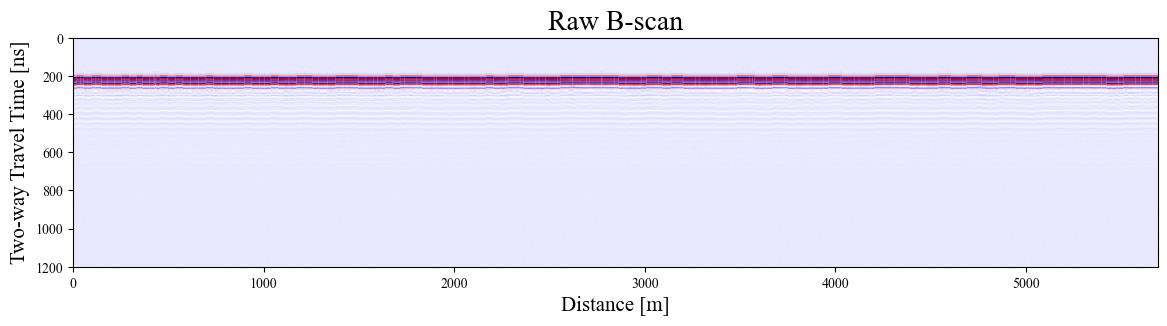

In [80]:
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'serif',  # Often a default in MATLAB
    'font.serif': ['Times New Roman'],
    'axes.labelsize': 15,
    'axes.titlesize': 20,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 1.5,
    'lines.marker': 'o',  # Example marker, adjust as needed
    'grid.color': 'lightgray',
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'axes.grid': False,
    'figure.subplot.wspace': 0,  # Example: Increase horizontal spacing
    'figure.subplot.hspace': 0.4,  # Example: Increase vertical spacing
    'figure.figsize': (14, 4) # Adjust figure size
})
rows, cols = raw.shape
plt.imshow(raw, cmap='seismic', extent = [0, cols, observable_depth_ns, 0])
plt.title("Raw B-scan")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")
print(np.amax(raw), np.amin(raw))
# 3.5e7 to 7.5e7

Text(0, 0.5, 'Two-way Travel Time [ns]')

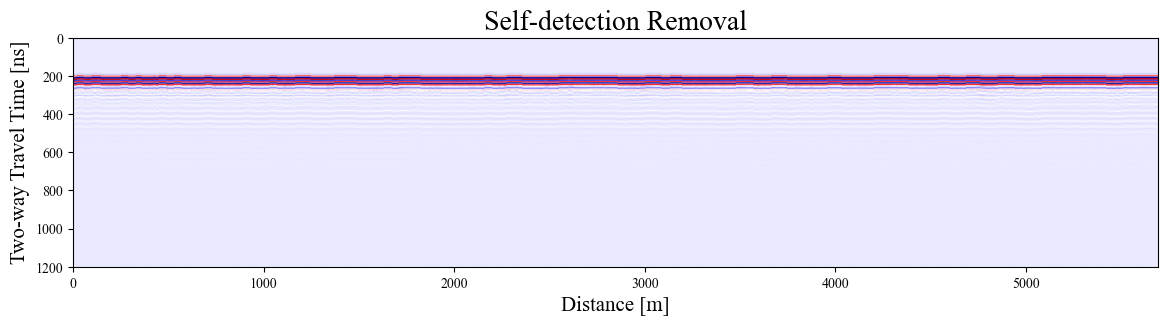

In [81]:
# self_detection = gain.apply_gain(self_detection, param=0.015, gain_type='exponential')
plt.imshow(self_detection, cmap='seismic',extent = [0, cols, observable_depth_ns, 0])
plt.title("Self-detection Removal")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")

27128466.0 -24998366.0


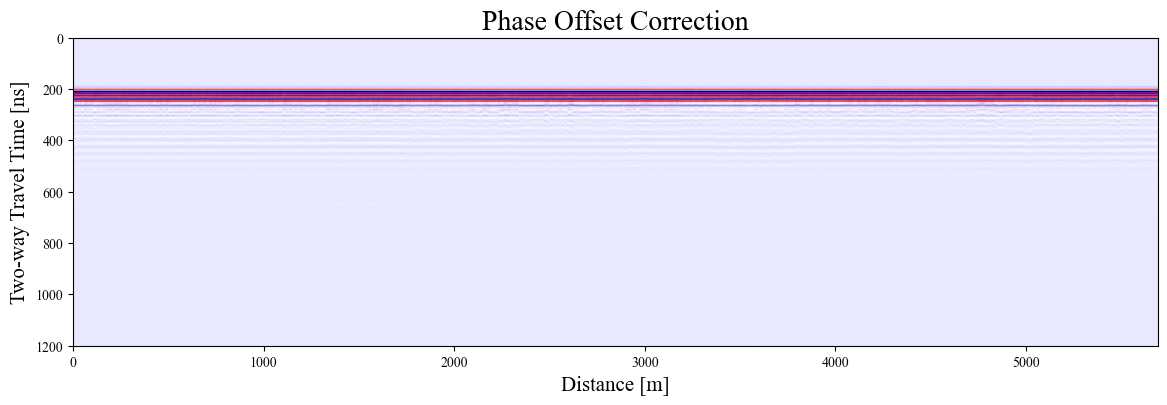

In [82]:
plt.imshow(norm2d(phase_offset), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("Phase Offset Correction")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")
print(np.amax(phase_offset), np.amin(phase_offset))

# Remove Horizontal Band and Ringing

2817881.43359375 -2621488.445


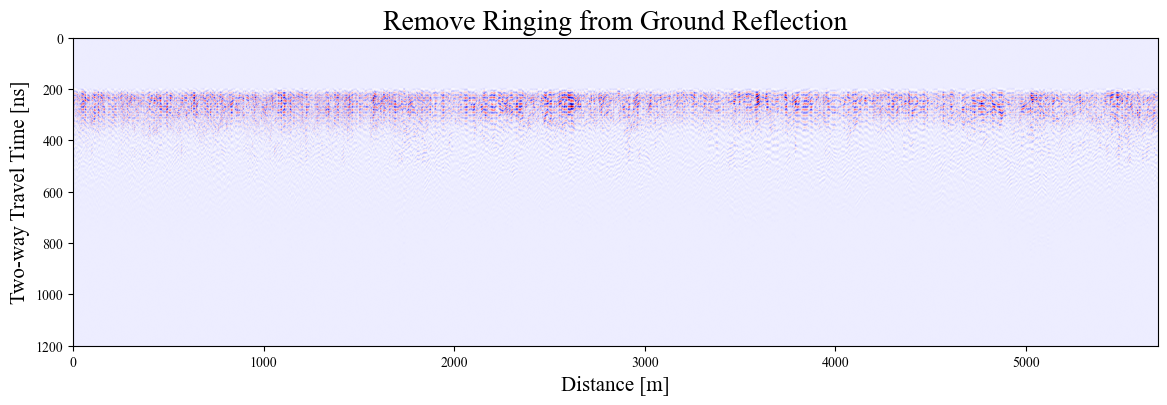

In [83]:
arr, shape = bgr.remove_bg(phase_offset)
arr, shape = bgr.subtract_window_mean(arr, 50)
plt.imshow(norm2d(arr), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("Remove Ringing from Ground Reflection")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")
print(np.amax(arr), np.amin(arr))

# Remove duplicate traces

/Users/coltenrodriguez/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/coltenrodriguez/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0, 0.5, 'Two-way Travel Time [ns]')

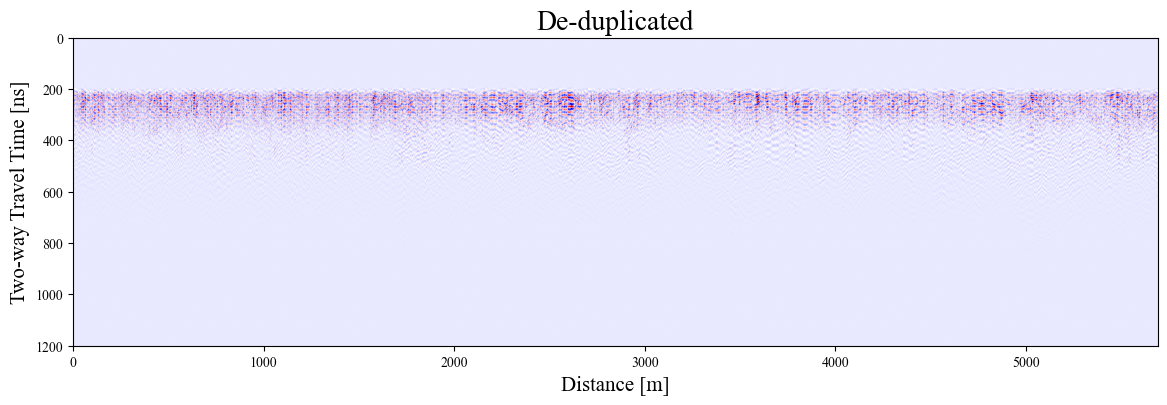

In [85]:
arr, duplicates, anom = bgr.dedupe(arr, arr.shape)
plt.imshow(norm2d(arr), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("De-duplicated")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")

# Lateral Energy Equalization

Text(0, 0.5, 'Two-way Travel Time [ns]')

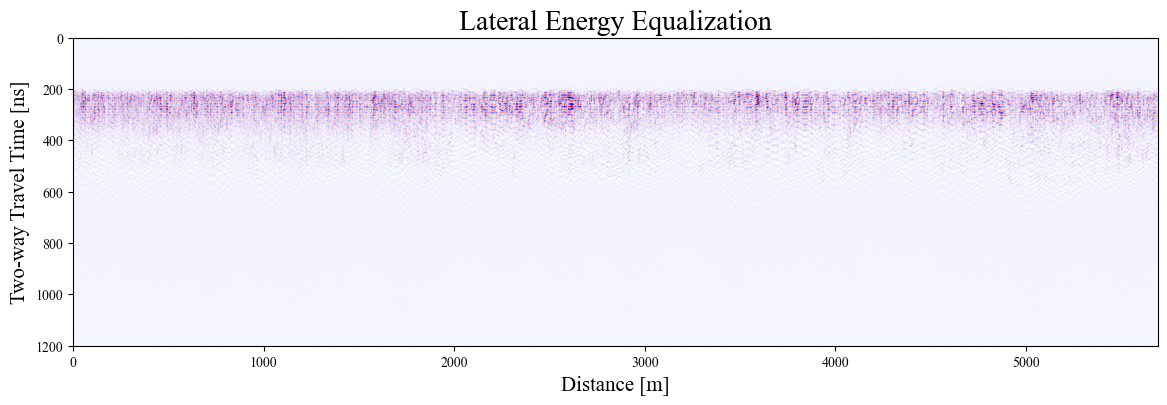

In [86]:
arr = energy_eq.lateral_energy_equalization(arr, 5)
plt.imshow(norm2d(arr), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("Lateral Energy Equalization")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")

# Apply Gain

12014373.330450034 -11009224.257169709


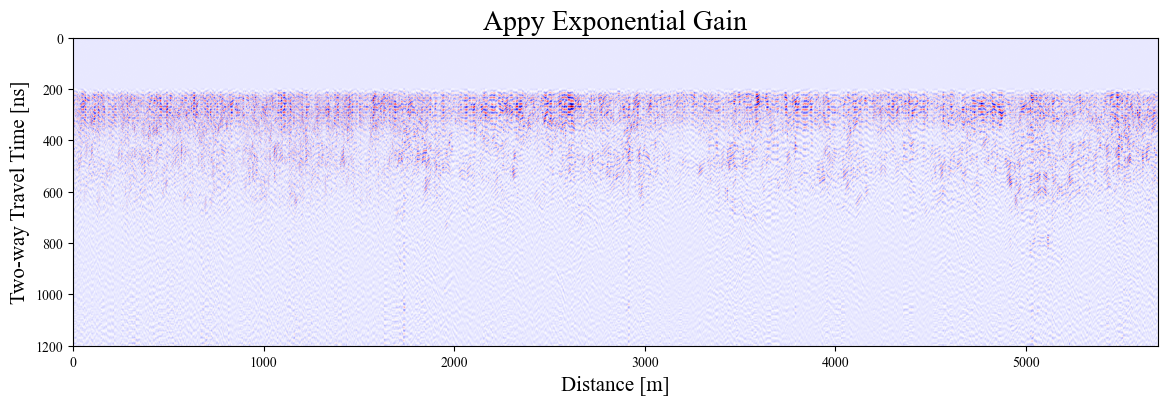

In [87]:
p = gain.apply_gain(arr, 0.014, gain_type='exponential', agc_window=90)
plt.imshow(norm2d(p), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("Appy Exponential Gain")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")
print(np.amax(p), np.amin(p))

In [106]:
upper_visible = 200
lower_visible = 620

Text(0, 0.5, 'Two-way Travel Time [ns]')

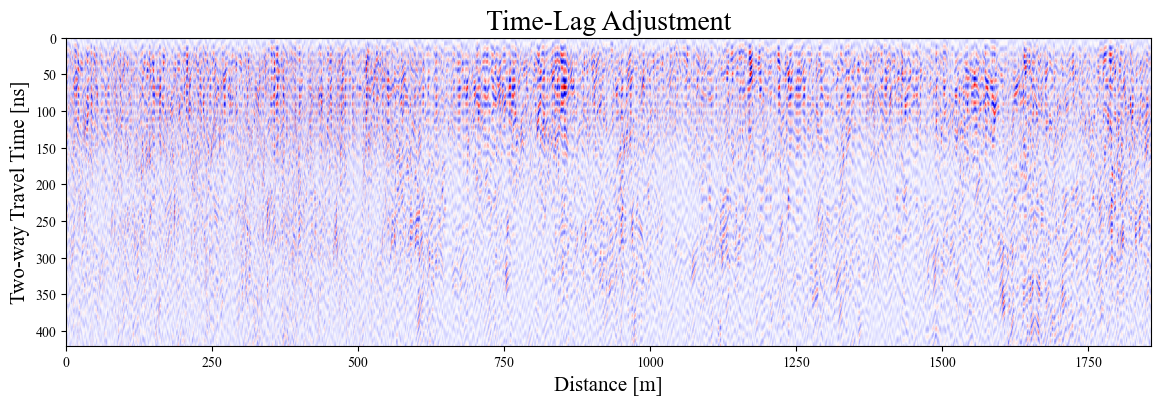

In [107]:
a = p[int(upper_visible*px_per_ns):int(lower_visible*px_per_ns), :]
plt.imshow(norm2d(a), cmap='seismic', aspect='auto', extent = [0, trace_dist_m, lower_visible-upper_visible, 0])
plt.title("Time-Lag Adjustment")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")

[   0.     309.625  619.25   928.875 1238.5   1548.125 1857.75 ]
309 420
310 420
309 420
310 420
310 420
309 420


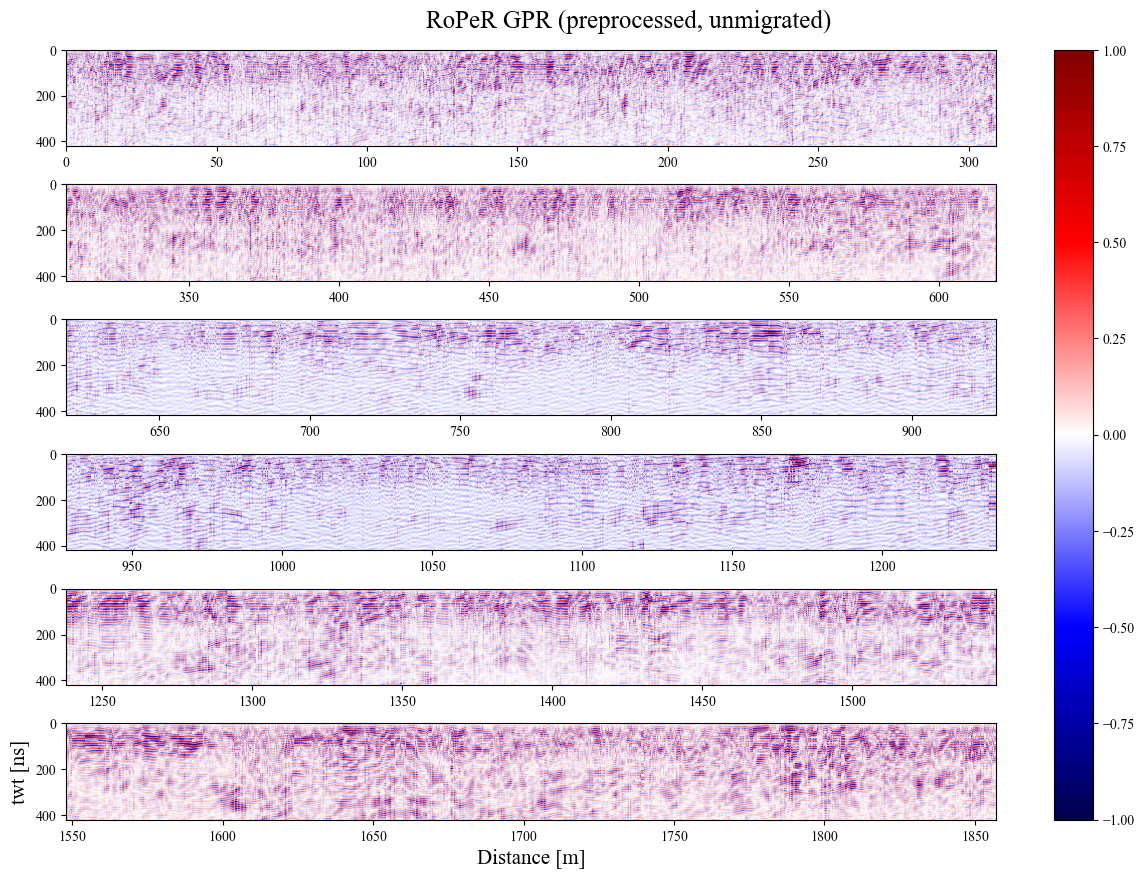

In [109]:
arr = a
n_plots = 6
fig, ax = plt.subplots(n_plots, 1, figsize=(15,10))
step = int(arr.shape[1]/n_plots)
scans = [arr[:, n*step:(n+1)*step] for n in range(0,n_plots)]
trace_dist_iterator = np.array([0, 1, 2, 3, 4, 5, 6])*trace_dist_m/n_plots
print(trace_dist_iterator)

def norm2d(array):
    min_val = np.min(array)
    max_val = np.max(array)
    
    # Apply the normalization formula
    normalized_array = 2 * ((array - min_val) / (max_val - min_val)) - 1
    
    return normalized_array

for i in range(0,len(scans)):
    scan = scans[i]
    d = int(trace_dist_iterator[i+1])-int(trace_dist_iterator[i])
    observable_depth = lower_visible-upper_visible
    print(d, observable_depth)
    plot = ax[i].imshow(norm2d(scan), extent=[int(trace_dist_iterator[i]), int(trace_dist_iterator[i+1]), observable_depth, 0], aspect='auto', origin='upper', cmap='seismic')
    if i == len(scans)-1:
        cbar = fig.colorbar(plot, ax=ax.ravel().tolist(), orientation='vertical')
        ax[i].set_xlabel("Distance [m]")
        ax[i].set_ylabel("twt [ns]")
    fig.suptitle("RoPeR GPR (preprocessed, unmigrated)", fontsize=18, y=0.92)
    